In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03ff\u1f00-\u1fff]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"
            else:
                for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                    match = re.search(regex_pattern, text)
                    if match:
                        pred = lang_code
                        break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
77281,other,Ho iniziato il mio strumento da quando non mi ...
11321,other,J'ai un téléphone huawei P20 et je n'arrive pa...
126,other,"( اذا كنت تشك في هذا , اقرا كتاب ( مات ريدلي ا..."
34428,other,първата му грижа беше да си върже китката .
37234,other,จาก ตัวแทน จาก กลาโหม กรม ฯ ไม่มี โปรแกรม นักเ...
...,...,...
76304,other,El horno llegó un día antes del plazo indicado...
10129,other,"Örneğin , bir sanayi vaka çalışma kuruluşu , p..."
18106,other,Um comboio de passageiros em espera numa estação.
68219,other,"150 имаше пауза , а после томи се върна към см..."


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,El horno llegó un día antes del plazo indicado...
23996,other,"Örneğin , bir sanayi vaka çalışma kuruluşu , p..."
23997,other,Um comboio de passageiros em espera numa estação.
23998,other,"150 имаше пауза , а после томи се върна към см..."


### Greek-Greeklish identification dataset

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.crawling import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.27it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.39it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.02it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.16it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.37it/s]


Processing page 7 of 8...


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  5.18it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.37it/s]


Processing page 8 of 8...


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  5.40it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.53it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

414

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [15]:
warmane_df = warmane_df[~empty_contents]

In [16]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(warmane_df.contents)

In [17]:
warmane_df[preds=="en"].contents

id
2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
2557881                          Paokara einai padou file :P
2602989    Me to plevro ton Allience ayti ti fora Oi <<An...
2877428         kalos private aksizei na ksekiniseis paidia?
2801654                                     Bump! ICC25 6/12
2873339    Kalhspera tha ithela na rwthsw an kapoios gnwr...
Name: contents, Length: 227, dtype: object

In [18]:
warmane_df[preds=="greeklish"].contents

Series([], Name: contents, dtype: object)

In [19]:
warmane_df[preds=="el"].contents

id
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
2609122    πώρωση με τα μισά Dung, Quests και Raids bugge...
2707437    Λοιπόν μαγες,ξέρει κάποιος γιατί δεν γίνεται ν...
2777071    INACTIVE\n\n\n <Northern Defiance>  Καινούργια...
3069941    Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2410495    Εμπειρια εχω, αλλα δεν εχω χρονο...αυτο ειναι ...
Name: contents, Length: 180, dtype: object

In [20]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": warmane_df.contents})
gold2_df

,labels,text
id,,
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12


In [21]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12
2873339,greeklish,Kalhspera tha ithela na rwthsw an kapoios gnwr...


In [22]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file)
    print(f"File saved successfully as {file}")

In [23]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [42]:
from src.crawling import ChromeDriverManager, jupyter_options


ChromeDriverManager.set_options(jupyter_options())

In [140]:
from tasks.youtube import scrape_youtube, extract_search_results, extract_comments


# "greek songs" search in Greek
song_search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), song_search_url, max_scrolls=5, verbose=True)
results_search_song = extract_search_results(search_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [142]:
gaming_search_url = "https://www.youtube.com/results?search_query=greek+fortnite"
gaming_soup = scrape_youtube(ChromeDriverManager.get(), gaming_search_url, max_scrolls=5, verbose=True)
results_search_gaming = extract_search_results(gaming_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [143]:
results_df = pd.DataFrame({"title": results_search_song[0] + results_search_gaming[0],
                           "link":  results_search_song[1] + results_search_gaming[1]})
results_df

,title,link
0,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...
1,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...
2,\n\nΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Που...,/watch?v=C4f3xcZzr3s&pp=ygUjzrXOu867zrfOvc65zr...
3,\n\nGreek Ultra Hits Non Stop Mix By Nikos Hal...,/watch?v=KhCU68Eok9E&pp=ygUjzrXOu867zrfOvc65zr...
4,\n\nΌμορφα ελληνικά τραγούδια\n,/watch?v=UIfND1RykJc&pp=ygUjzrXOu867zrfOvc65zr...
...,...,...
272,\n\nΓΙΑ ΚΑΘΕ DEATH ΠΙΝΩ 1 ΓΟΥΛΙΑ ΝΕΡΟ CHALLENG...,/watch?v=6869pq4DZPg&pp=ygUOZ3JlZWsgZm9ydG5pdG...
273,\n\nΘα Χωρίσω Εξαιτίας Του Fortnite…\n,/watch?v=jla9IrQAIkk&pp=ygUOZ3JlZWsgZm9ydG5pdG...
274,\n\nΤΟ TILTED TOWERS ΕΠΕΣΤΡΕΨΕ ΚΑΙ ΤΟ ΚΑΤΑΚΤΑΜ...,/watch?v=1d8dXGe3tEk&pp=ygUOZ3JlZWsgZm9ydG5pdG...
275,\n\n🔴 OG FORTNITE STREAM Fortnite Greek Live S...,/watch?v=omXf7LzcCAY&pp=ygUOZ3JlZWsgZm9ydG5pdG...


In [144]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
1,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...
2,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...
3,Greek Ultra Hits Non Stop Mix By Nikos Halkous...,https://www.youtube.com/watch?v=KhCU68Eok9E&pp...
4,Όμορφα ελληνικά τραγούδια,https://www.youtube.com/watch?v=UIfND1RykJc&pp...
...,...,...
272,ΓΙΑ ΚΑΘΕ DEATH ΠΙΝΩ 1 ΓΟΥΛΙΑ ΝΕΡΟ CHALLENGE! (...,https://www.youtube.com/watch?v=6869pq4DZPg&pp...
273,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...
274,ΤΟ TILTED TOWERS ΕΠΕΣΤΡΕΨΕ ΚΑΙ ΤΟ ΚΑΤΑΚΤΑΜΕ! (...,https://www.youtube.com/watch?v=1d8dXGe3tEk&pp...
275,🔴 OG FORTNITE STREAM Fortnite Greek Live Strea...,https://www.youtube.com/watch?v=omXf7LzcCAY&pp...


In [146]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
2,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...
4,Όμορφα ελληνικά τραγούδια,https://www.youtube.com/watch?v=UIfND1RykJc&pp...
6,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
8,"Πουλόπουλος, Μπάσης, Γλυκερία, Ανδρεάτος, Μπέλ...",https://www.youtube.com/watch?v=cOGip_clrKY&pp...
...,...,...
270,🔴Χαλαρά Practice w/Duo best ps4 gr GREEK LIVE🏆,https://www.youtube.com/watch?v=C2AyZPtSEjE&pp...
271,ΣΚΟΤΩΣΑ ΤΟΝ MONGRAAL ME 2OBOMB !,https://www.youtube.com/watch?v=ZTJPZJ453dY&pp...
272,ΓΙΑ ΚΑΘΕ DEATH ΠΙΝΩ 1 ΓΟΥΛΙΑ ΝΕΡΟ CHALLENGE! (...,https://www.youtube.com/watch?v=6869pq4DZPg&pp...
273,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...


In [147]:
import bs4
import threading


def scrape_job(yt_url: str) -> tuple[str, bs4.BeautifulSoup]:
    try:
        result = scrape_youtube(ChromeDriverManager.get(), 
                                yt_url, 
                                scroll_wait_secs=2,
                                max_scrolls=15,
                                verbose=False)
    except Exception:
        result = None
    return yt_url, result

In [148]:
import concurrent.futures


jobs = 15
# get at most max_videos, if more videos were crawled during the search
max_videos = 150
urls = gr_res_df.link.sample(max_videos) if len(gr_res_df) > max_videos else gr_res_df

print("Scrapping comments...")
with concurrent.futures.ThreadPoolExecutor(max_workers=jobs) as executor:
    scrape_results = list(tqdm(executor.map(scrape_job, urls), total=len(urls)))

ChromeDriverManager.quit()

Scrapping comments...


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [05:23<00:00,  2.16s/it]


In [150]:
from tasks.youtube import extract_comments


scraped_urls = []
comments = []
dates = []

success = 0
for url, result in scrape_results:
    if result is not None:
        new_comments, new_dates = extract_comments(result)
        comments += new_comments
        dates += new_dates
        scraped_urls += ([url] * len(new_comments))
        success += 1
        
print(f"Processed {success} videos with comments, {len(scrape_results) - success} empty .")

Processed 150 videos with comments, 0 empty .


In [151]:
comments_df = pd.DataFrame({"link": scraped_urls, "text": comments, "date": dates})
comments_df

,link,text,date
0,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,Τον απολάμβαναν στα 16 μου και συνεχίζω να τον...,2023-07-25 20:53:32.899031
1,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,Ο πιο ρομαντικός στιχουργός!Με συγκινούν οι δη...,2021-11-25 20:53:32.903080
2,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,Τον αγαπάς από τους στοίχους του \nΤον λατρεύε...,2021-11-25 20:53:32.907051
3,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,Οι στιχοι του ειναι ταξιδιαρικα πουλια που αγγ...,2022-11-25 20:53:32.911142
4,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,Υπερασπίσου το παιδί\r\nγιατί αν γλιτώσει το π...,2021-11-25 20:53:32.914171
...,...,...,...
2167,https://www.youtube.com/watch?v=rhiaHQ_S1Jk&pp...,Σ,2021-11-25 20:53:43.151460
2168,https://www.youtube.com/watch?v=rhiaHQ_S1Jk&pp...,Skatamo,2021-11-25 20:53:43.154492
2169,https://www.youtube.com/watch?v=rhiaHQ_S1Jk&pp...,Third,2021-11-25 20:53:43.157493
2170,https://www.youtube.com/watch?v=rhiaHQ_S1Jk&pp...,δετυ,2021-11-25 20:53:43.160509


In [152]:
comments_df.date = comments_df.date.apply(lambda x: x.date() if x is not None else None)

preds = greeklish_model.predict(comments_df.text)
mask = ((preds != "el") & (preds != "greeklish"))
comments_df[mask]

,link,text,date
18,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,Papadopoulos is one of the greatest lyricists ...,2023-07-25
29,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,I immediately feel in Greece. Agapo tis tragou...,2022-11-25
36,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,Whoever has organized this video have done a g...,2022-11-25
43,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,"Guau!!!!Gracias,maravilloso.",2021-11-25
58,https://www.youtube.com/watch?v=n2-TCkHFqi0&pp...,Beautiful,2021-11-25
...,...,...,...
2165,https://www.youtube.com/watch?v=rhiaHQ_S1Jk&pp...,Second,2021-11-25
2166,https://www.youtube.com/watch?v=rhiaHQ_S1Jk&pp...,first,2021-11-25
2168,https://www.youtube.com/watch?v=rhiaHQ_S1Jk&pp...,Skatamo,2021-11-25
2169,https://www.youtube.com/watch?v=rhiaHQ_S1Jk&pp...,Third,2021-11-25


In [153]:
crawl_df = pd.merge(gr_res_df, comments_df, how="inner", on="link")
crawl_df

,title,link,text,date
0,Κανείς Εδώ Δεν Τραγουδά - Kaneis Edw Den Trago...,https://www.youtube.com/watch?v=SlJ9x3A0NmU&pp...,Τον απολάμβαναν στα 16 μου και συνεχίζω να τον...,2023-07-25
1,Κανείς Εδώ Δεν Τραγουδά - Kaneis Edw Den Trago...,https://www.youtube.com/watch?v=SlJ9x3A0NmU&pp...,Ο πιο ρομαντικός στιχουργός!Με συγκινούν οι δη...,2021-11-25
2,Κανείς Εδώ Δεν Τραγουδά - Kaneis Edw Den Trago...,https://www.youtube.com/watch?v=SlJ9x3A0NmU&pp...,Τον αγαπάς από τους στοίχους του \nΤον λατρεύε...,2021-11-25
3,Κανείς Εδώ Δεν Τραγουδά - Kaneis Edw Den Trago...,https://www.youtube.com/watch?v=SlJ9x3A0NmU&pp...,Οι στιχοι του ειναι ταξιδιαρικα πουλια που αγγ...,2022-11-25
4,Κανείς Εδώ Δεν Τραγουδά - Kaneis Edw Den Trago...,https://www.youtube.com/watch?v=SlJ9x3A0NmU&pp...,Υπερασπίσου το παιδί\r\nγιατί αν γλιτώσει το π...,2021-11-25
...,...,...,...,...
2286,"Νέο Season, Ακόμα Άχρηστος! (Fortnite Zero Bui...",https://www.youtube.com/watch?v=H-TIQdWiuOg&pp...,First,2023-11-04
2287,"Νέο Season, Ακόμα Άχρηστος! (Fortnite Zero Bui...",https://www.youtube.com/watch?v=H-TIQdWiuOg&pp...,Προτος,2023-11-04
2288,"Νέο Season, Ακόμα Άχρηστος! (Fortnite Zero Bui...",https://www.youtube.com/watch?v=H-TIQdWiuOg&pp...,Φίλε δεν ξέρω που ακουσες το γι παντα. 1 μηνα ...,2023-11-11
2289,"Νέο Season, Ακόμα Άχρηστος! (Fortnite Zero Bui...",https://www.youtube.com/watch?v=H-TIQdWiuOg&pp...,Πρωτος,2023-11-04


In [154]:
sum(crawl_df.date == None)

0

## Language Identification

https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he
https://gking.harvard.edu/files/abs/0s-abs.shtml
https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data


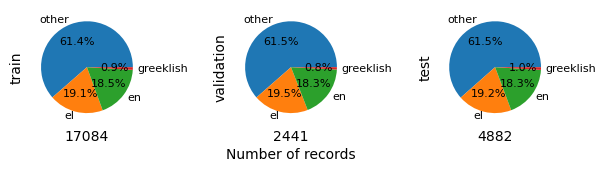

In [56]:
from src.ml import train_test_val_split
import matplotlib.pyplot as plt


data_train, data_val, data_test = train_test_val_split(gold_df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2,
                                                        random_state=42, stratify_col="labels")
# code block from Ioannis Pavlopoulos
axes = pd.DataFrame({"train": data_train.labels.value_counts(),
              "validation": data_val.labels.value_counts(),
              "test": data_test.labels.value_counts()}
            ).plot.pie(subplots=True, 
                       textprops={'fontsize': 8},
                       autopct=f'%1.1f%%', # print percent% results 
                       legend=False)

axes[0].set_xlabel(data_train.shape[0])
axes[1].set_xlabel(data_val.shape[0])
axes[2].set_xlabel(data_test.shape[0])

axes[1].text(0, -2, 'Number of records', ha='center')

plt.tight_layout(pad=2.0)
plt.show()

In [57]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_val = vectorizer.transform(data_val.text)
y_val = data_val.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

In [58]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [59]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.19046411361907176
              precision    recall  f1-score   support

          el       0.00      0.00      0.00       936
          en       0.00      0.00      0.00       895
   greeklish       0.00      0.00      0.00        47
       other       0.62      1.00      0.76      3004

    accuracy                           0.62      4882
   macro avg       0.15      0.25      0.19      4882
weighted avg       0.38      0.62      0.47      4882



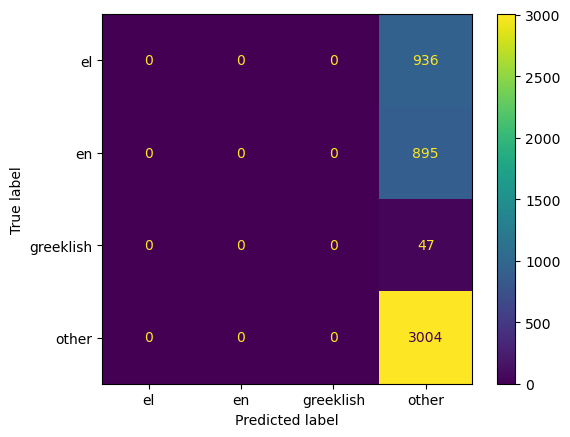

In [60]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [61]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.4758, std: 0.4720


Macro F1: 0.4627104282717093
              precision    recall  f1-score   support

          el       1.00      0.72      0.84       936
          en       0.31      1.00      0.48       895
   greeklish       0.00      0.00      0.00        47
       other       1.00      0.37      0.54      3004

    accuracy                           0.55      4882
   macro avg       0.58      0.52      0.46      4882
weighted avg       0.86      0.55      0.58      4882



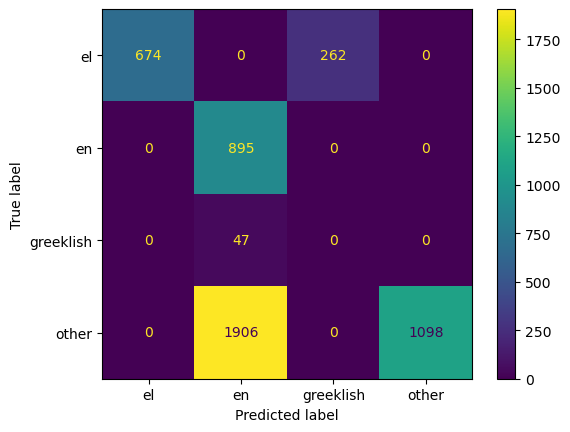

In [62]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8484, std: 0.8903


Macro F1: 0.9074296552311165
              precision    recall  f1-score   support

          el       1.00      0.94      0.97       936
          en       0.99      0.97      0.98       895
   greeklish       1.00      0.53      0.69        47
       other       0.97      1.00      0.98      3004

    accuracy                           0.98      4882
   macro avg       0.99      0.86      0.91      4882
weighted avg       0.98      0.98      0.98      4882



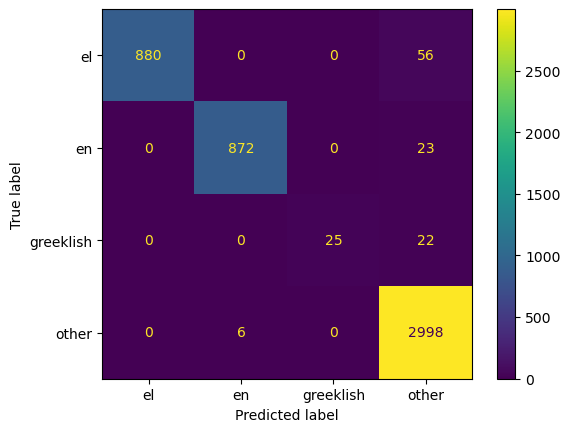

In [64]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

### Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=3)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Random Forest mean macro F1: 0.9400, std: 0.9279


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Macro F1: 0.9593687773786809
              precision    recall  f1-score   support

          el       1.00      0.98      0.99       936
          en       0.98      1.00      0.99       895
   greeklish       1.00      0.77      0.87        47
       other       0.99      0.99      0.99      3004

    accuracy                           0.99      4882
   macro avg       0.99      0.93      0.96      4882
weighted avg       0.99      0.99      0.99      4882



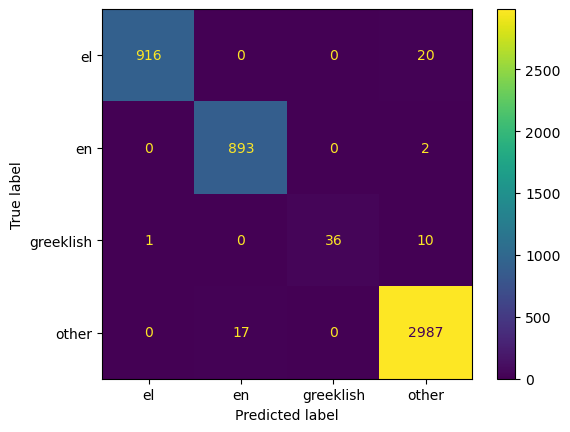

In [66]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

Macro F1: 0.9066843106336655
              precision    recall  f1-score   support

          el       0.99      0.89      0.94       936
          en       0.97      0.96      0.96       895
   greeklish       0.89      0.66      0.76        47
       other       0.95      0.99      0.97      3004

    accuracy                           0.96      4882
   macro avg       0.95      0.87      0.91      4882
weighted avg       0.96      0.96      0.96      4882



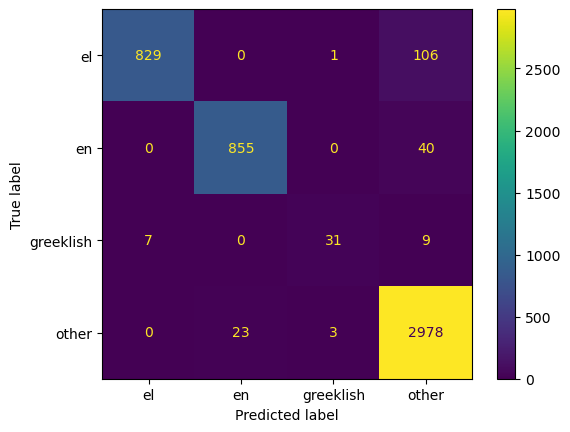

In [68]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [69]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
7466,other,en,Works better than expected
1738,other,el,Όλα τα μάτια στράφηκαν σ ' αυτόν .
6062,other,el,"Αλήθεια , πού ζείτε τώρα ;"
795,other,en,Exactly what I was hoping I would get.
20151,en,other,Volgens marktonderzoek van The NPD Group is he...
...,...,...,...
1929,other,en,FAULTY - All stopped functioning within 1 week
6271,other,el,"Ω , Θεέ μου , την αγαπώ ."
8100,other,el,καλά μου φαίνεται ότι πληρώνω ούτως ή άλλως γι...
3463,other,el,Είχε προβλέψει αυτή τη σύλληψη ;


In [70]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
14497,en,other,Oh that ' s sort of the way we know do it or a...
4026,other,el,Η αποικία σιγά σιγά έγινε καλύτερα οργανωμένη .
13082,en,other,Nilienda huko kwa underground when that was yo...
2696563,other,greeklish,"tipota se pvp den exei oloi pve kanete?? -,-"
10519,en,other,Ooh i got ahead of you hapo nilipata tatu na m...
3107924,other,greeklish,K r o b a i n h
2434,other,el,Φαγητό : 4 αστέρια .
14882,en,other,As raparigas dançaram no palco.
878,other,el,Κοίταξα γύρω .
1444,other,el,"Τίποτα , κυρία κάβεντις ;"


### Hyperparameter tuning

In [71]:
estimators = []
scores = []

for n_estimators in tqdm([int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]):
    estim = RandomForestClassifier(n_estimators=n_estimators, 
                                  n_jobs=-1, 
                                  criterion="entropy").fit(x_train, y_train)
    score = f1_score(y_val, estim.predict(x_val), average='macro', zero_division=0)

    estimators.append(estim)
    scores.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:17<00:00, 75.45s/it]


In [72]:
best_model = estimators[np.argmax(scores)]
print(f"Best model {best_model} with macro F1 score of {max(scores)}")

Best model RandomForestClassifier(criterion='entropy', n_jobs=-1) with macro F1 score of 0.9801142658762548


### Annotating the operational dataset

In [73]:
x_oper = vectorizer.transform(crawl_df.text)
crawl_df["language"] = best_model.predict(x_oper)

In [74]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


### Exploring the operational dataset

In [83]:
RESOURCE_OUTPUT = "results"

def save_plot(filename):
    path = os.path.join(RESOURCE_OUTPUT, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

Figured saved to results\lang_dis.png


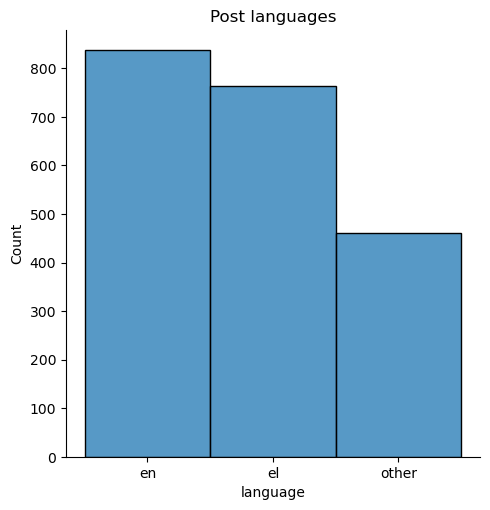

In [108]:
import seaborn as sns


sns.displot(crawl_df.language)
save_plot("lang_dis.png")
plt.title("Post languages")
plt.show()

In [101]:
languages = np.unique(crawl_df.language)

lang_col = []
len_col = []

for language in languages:
    comments_text = crawl_df.loc[crawl_df.language == language, "text"]
    comments_length = comments_text.apply(lambda x: len(x))
    
    lang_col += [language] * len(comments_length)
    len_col += list(comments_length)

len_df = pd.DataFrame({"language": lang_col, "comment_length": len_col})

Figured saved to results\length_dis.png


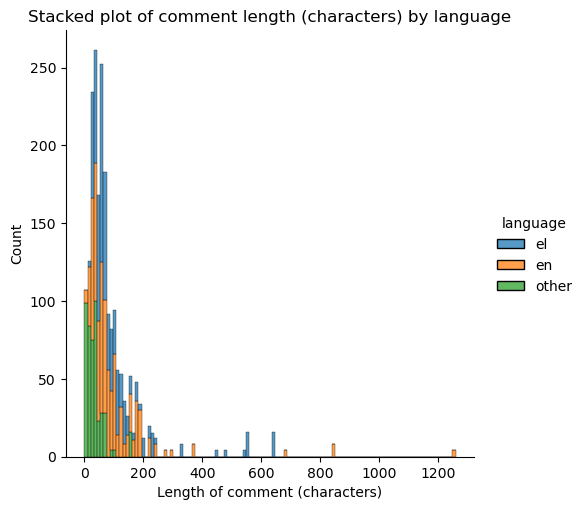

In [111]:
sns.displot(len_df, x="comment_length", hue="language", multiple="stack")
plt.title("Stacked plot of comment length (characters) by language")
plt.xlabel("Length of comment (characters)")
save_plot("length_dis.png")
plt.show()

In [118]:
emoji_pattern = re.compile(
    r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF'
    r'\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF'
    r'\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\u2600-\u26FF\u2700-\u27BF'
    r'\u2B50\u2B06\u2934\u2935\u2B05\u2194-\u2199\u21A9\u21AA\u2139\u2328'
    r'\u23CF\u23E9-\u23F3\u231A\u23F8-\u23FA\u231B\u23F0\u231A\u1F004'
    r'\u1F0CF\u1F18E\u3030\u303D]'
)

emojis_col = []

for language in languages:
    comments_text = crawl_df.loc[crawl_df.language == language, "text"]
    comments_length = comments_text.apply(lambda x: len(emoji_pattern.findall(x)))

    emojis_col += list(comments_length)

emoji_df = pd.DataFrame({"language": lang_col, "emojis": emojis_col})

['😊', '🌍', '🚀']


Figured saved to results\emojis_dis.png


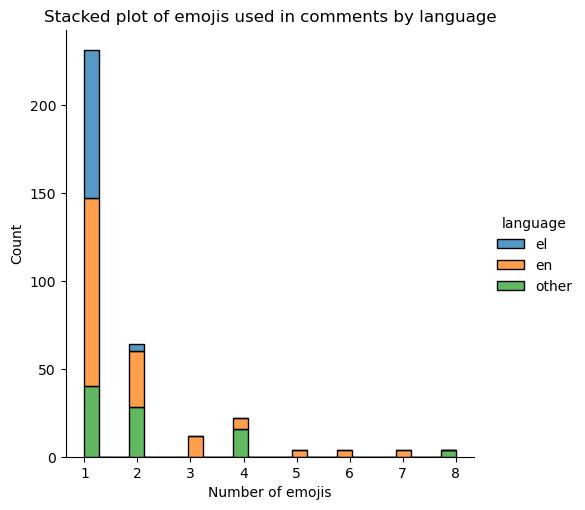

In [124]:
sns.displot(emoji_df[emoji_df.emojis > 0] , x="emojis", hue="language", multiple="stack")
plt.title("Stacked plot of emojis used in comments by language")
plt.xlabel("Number of emojis")
save_plot("emojis_dis.png")
plt.show()

In [131]:
date_df = crawl_df.groupby(by=["date", "language"]).count()
date_df.head(2)

title  link  text
date       language                   
2017-11-25 el           45    45    45
           en          108   108   108

Figured saved to results\time_plot.png


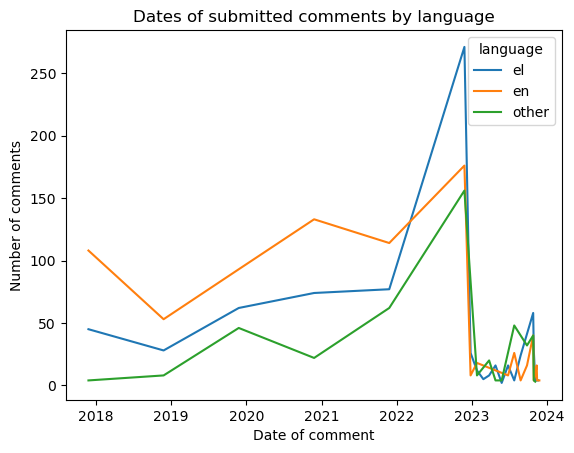

In [139]:
sns.lineplot(x="date", y="text", hue="language", data=date_df)
plt.title("Dates of submitted comments by language")
plt.xlabel("Date of comment")
plt.ylabel("Number of comments")

save_plot("time_plot.png")
plt.show()

In [ ]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")